In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import pandas_datareader.data as web
from time import sleep
import quandl
import seaborn as sns
import sys
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import urllib
from datetime import date , timedelta

import requests
import json
import re

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Can we use Macro Momentum to predict gold?

-  High yield spread
- Change in yield curve
- Gold Trend


In [2]:
yiedl_10_2_tmp = web.DataReader('T10Y2Y','fred', '1970-01-01')# Daily
HY_spread_tmp = web.DataReader('BAMLH0A0HYM2','fred', '1970-01-01') # Daily
real_rate_tmp = web.DataReader('REAINTRATREARAT10Y','fred', '1970-01-01') # Daily

In [3]:
diff = 12 * 4

yiedl_10_2_change = yiedl_10_2_tmp.resample('W').last()
yiedl_10_2_change = yiedl_10_2_change.diff(diff)

HY_change = HY_spread_tmp.resample('W').last()
HY_change = HY_change.diff(diff)

yiedl_10_2_change.columns = ['curve_chg']
HY_change.columns = ['HY_chg']

In [4]:
# Gold
gld_daily_tmp = yf.download("GLD")
gld_daily= pd.DataFrame(gld_daily_tmp['Close'])
gld_daily.columns = ['Gold Trend']
gld_monthly = gld_daily.resample('W').last()
gld_trend = gld_monthly.pct_change(diff)

[*********************100%***********************]  1 of 1 completed


In [5]:
tol = pd.Timedelta('5 day')

data_tmp = pd.concat([yiedl_10_2_change, HY_change],axis =1)
data_tmp = pd.merge_asof(left=data_tmp,right=gld_trend,right_index=True,left_index=True,direction='nearest',tolerance=tol)


signals = pd.DataFrame()

for signal in data_tmp.columns:
    signals.loc[:, signal] = [1 if x>0 else 0 for x in data_tmp[signal]]
    
    
signals.index = data_tmp.index
    
gold_ret = gld_daily.resample('W').last().pct_change().shift(-1)
gold_ret.columns = ['Gold']


In [107]:
res_tmp = pd.concat([signals, gold_ret],axis =1)
res_tmp = res_tmp.dropna()
res_tmp = pd.concat([signals, gold_ret],axis =1)
res_tmp = res_tmp.dropna()

columns = list(res_tmp.columns)
columns.remove("Gold")

res = res_tmp[columns].multiply(res_tmp["Gold"], axis="index")
res['Comb'] = res[columns].mean(axis = 1) #Combined Strategy
res['Gold'] = res_tmp['Gold']

In [108]:
res = (res+1).cumprod()

<AxesSubplot:>

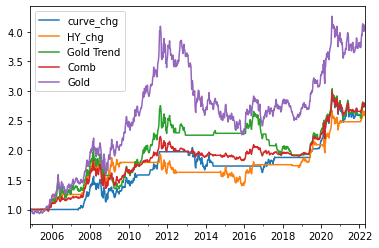

In [111]:
res.plot()

In [14]:
np.random.seed(123)
train_ratio = 0.7

import shap
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import sklearn


reg_df = pd.concat([data_tmp, gold_ret],axis =1)
reg_df = reg_df.dropna()

eval_train_df = reg_df[:int(len(reg_df)*train_ratio)]
eval_test_df =  reg_df[int(len(reg_df)*(1-train_ratio)):]

X_ml = reg_df[['curve_chg', 'HY_chg', 'Gold Trend']]
Y_ml = pd.DataFrame(reg_df[['Gold']])

#splitting data into train and test
X_train = X_ml[:int(len(X_ml)*train_ratio)]
X_test = X_ml[int(len(X_ml)*(1-train_ratio)):]
Y_train = Y_ml[:int(len(X_ml)*(train_ratio))]
Y_test = Y_ml[int(len(X_ml)*(1-train_ratio)):]

#creating dmatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [15]:
## TUNE WITH GRIDSEARCH


param_grid =  {'n_estimators': [600, 800, 1000],
               'max_features': ['auto'],
               'max_depth' : [2, 3],
               'min_samples_split': [0.01, 0.05, 0.1],
               #'min_samples_leaf': [0.01, 0.05, 0.1],
               'bootstrap': [True]}


rfc=RandomForestRegressor(random_state=20)
clf_rf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

clf_rf.fit(X_train, Y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20),
             param_grid={'bootstrap': [True], 'max_depth': [2, 3],
                         'max_features': ['auto'],
                         'min_samples_split': [0.01, 0.05, 0.1],
                         'n_estimators': [600, 800, 1000]})

In [16]:
clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_split': 0.01,
 'n_estimators': 600}

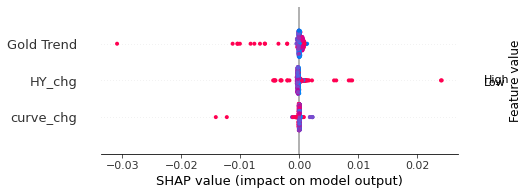

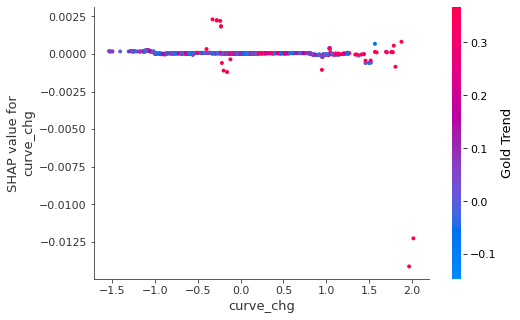

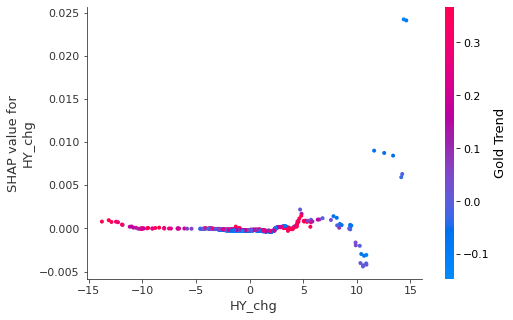

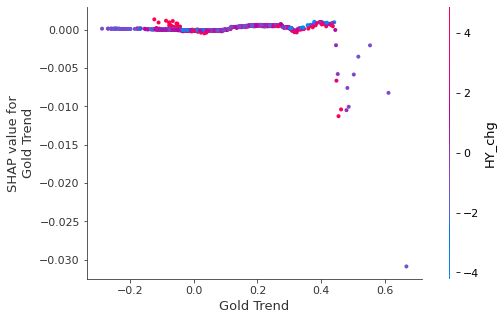

In [18]:
shap_values_ind_rf = shap.TreeExplainer(clf_rf.best_estimator_).shap_values(X_ml)

shap.summary_plot(shap_values_ind_rf,X_ml)
for var in ['curve_chg', 'HY_chg', 'Gold Trend']:
    shap.dependence_plot(var, shap_values_ind_rf, X_ml)#interaction_index=None